# Data manipulating and plotting of post compression simulation nanoparticle films

In [1]:
import numpy as np
from scipy.spatial import distance

from sklearn.cluster import dbscan, DBSCAN
import polyscope as ps

from ddgclib._sphere import *
from ddgclib._misc import *
from ddgclib._complex import Complex

### Load trimmed data from npy blobs

In [2]:
with open('./data/points_trimmed.npy', 'rb') as f:
    points = np.load(f, allow_pickle=True)  # NOTE: does not work yet

with open('./data/radii_trimmed.npy', 'rb') as f:
    radii = np.load(f)

### Plot in polyscope:

In [3]:
ps.init()
ps.set_up_dir("z_up")
ps_cloud = ps.register_point_cloud("Particles", points)
ps_cloud.add_scalar_quantity("Particle radii", radii)
ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
ps_cloud.set_color((1.0, 1.0, 1.0))
ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 495.44


## First build a unit sphere projection:

In [4]:
R = 1
#N = 200  # Note; irrelevant, only refinement is relevant
theta = np.linspace(0, 2 * np.pi)  # theta
phi = np.linspace(0, np.pi)  # phi
HC, bV = sphere_N(R, phi, theta, refinement=3, cdist=1e-2, equilibrium=True)


/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


(<Figure size 432x288 with 1 Axes>, <Axes3D:>, None, None)

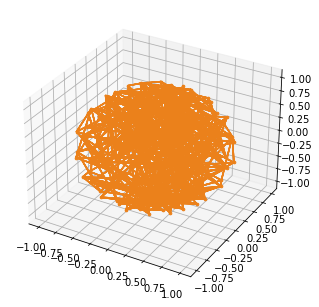

In [5]:
HC.plot_complex()

In [6]:
us_points = []
for v in HC.V:
    us_points.append(v.x)

In [7]:
us_points = np.array(us_points, dtype='float32')

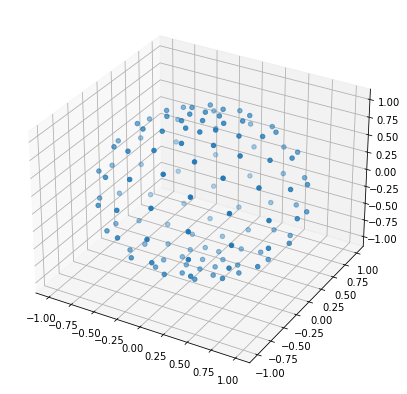

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(us_points[:, 0], us_points[:, 1], us_points[:, 2])
 
# show plot
plt.show()

### Now project this initiation for every nanoparticle:

In [9]:
water = []
water_particles = {}
h = 0.4 # nm, film thickness
for p, r in zip(points, radii):
    # Multiply by particle radius + film height:
    fluid_points = (r + h) * us_points 
    # move centres to point
    fluid_points +=p  
    print(f'p = {p}, r = {r}')
    print(f'fluid points = {fluid_points}')
    water.append(fluid_points)
    water_particles[tuple(p)] = fluid_points
    
water = np.array(water)

p = [-971.047 -971.457  294.949], r = 4.574999999999999
fluid points = [[-971.047   -971.457    299.924  ]
 [-971.047   -971.457    289.974  ]
 [-976.022   -971.457    294.949  ]
 [-966.072   -971.457    294.949  ]
 [-971.047   -974.97485  298.46686]
 [-971.047   -974.97485  291.43115]
 [-971.047   -967.93915  291.43115]
 [-971.047   -967.93915  298.46686]
 [-974.5649  -971.457    298.46686]
 [-967.5291  -971.457    298.46686]
 [-971.047   -976.432    294.949  ]
 [-967.79694 -974.7071   296.85284]
 [-972.39325 -972.8032   299.5453 ]
 [-974.29706 -974.7071   296.85284]
 [-969.70074 -972.8032   299.5453 ]
 [-974.5649  -971.457    291.43115]
 [-967.5291  -971.457    291.43115]
 [-967.79694 -974.7071   293.04514]
 [-969.70074 -972.8032   290.3527 ]
 [-974.29706 -974.7071   293.04514]
 [-972.39325 -972.8032   290.3527 ]
 [-971.047   -966.482    294.949  ]
 [-972.39325 -970.1108   290.3527 ]
 [-967.79694 -968.2069   293.04514]
 [-974.29706 -968.2069   293.04514]
 [-969.70074 -970.1108   290.

In [10]:
fluid_all = water.reshape(-1, water.shape[-1])
fluid_all.shape

(18056, 3)

In [11]:
ps.init()
ps.set_up_dir("z_up")
ps_cloud = ps.register_point_cloud("Water ", fluid_all#, radius=100
                                  )
#ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
ps_cloud.add_scalar_quantity("Particle radii", 0.2*np.ones(fluid_all.shape[0]))
ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
#ps_cloud.set_color(tuple(lb))
ps_cloud.set_color(tuple(db))
ps.show()

### Triangulate the points locally

In [12]:
from scipy.spatial import Delaunay, ConvexHull
import time
ts = time.time()
#verts = fluid_all
#hull = ConvexHull(verts)

hull_l = []
verts_l = []
points = []
simplices = []
for wp in water_particles:
    hull = ConvexHull(water_particles[wp])
    hull_l.append(hull)
    # Combine all simplices and points for the mesh
    points.append(hull.points)
    simplices.append(hull.simplices)
    
print(f'total time = {time.time() - ts}')
points = np.array(points)
simplices = np.array(simplices)
points_all = points.reshape(-1, points.shape[-1])
simplices_all = simplices.reshape(-1, simplices.shape[-1])

total time = 0.07730889320373535


In [13]:
HC_l = []
for i, hull in enumerate(hull_l):
    HC = Complex(3)
    for p in hull.points:
        HC.V[tuple(p)]
    for s in hull.simplices:
        for si in s:
            vi = HC.V[tuple(hull.points[si])]
            for sj in s:
                vj = HC.V[tuple(hull.points[sj])]
                vi.connect(vj)
    HC_l.append(HC)
    #ps_mesh = ps.register_surface_mesh(f"Fluid mesh Delaunay {i}", hull.points, hull.simplices)
    #ps_mesh.set_edge_color((0.0, 0.0, 0.0)) 
    #ps_mesh.set_edge_width(1.0)
    #ps_mesh.set_material("clay")

In [14]:
# This should be handled by DBCLUSTER, but the API is struggling at the moment
HC_i_clustered = []
HC_i_clustered_indices = []
cdist = 0.5
#cdist = 4
for i, hc in enumerate(HC_l):
    HC_i_clustered_indices.append([])
    hull_i = hull_l[i]
    
    if 1:
        # Use a previous complex if already merged 
        for l in range(i-1):
            if i in HC_i_clustered_indices[l]:
                # Define the current i complex to be a previous 
                # l <= i complex merged to current i:
                HC = HC_l[l]
                break
        else:
            HC_i_clustered.append(hc)
            HC = hc
    
    for j, hc2 in enumerate(HC_l):
        if i == j:
            continue
        hull_j = hull_l[j]
        dist = scipy.spatial.distance.cdist(hull_i.points, hull_j.points, 'euclidean')
        merge = (dist < cdist).any()
        
        if merge:
            # Register that index j is now merged with index i
            HC_i_clustered_indices[i].append(j)
            # merge routine:
            for p in hull_j.points:
                HC.V[tuple(p)]
            for s in hull_j.simplices:
                for si in s:
                    vi = HC.V[tuple(hull_j.points[si])]
                    for sj in s:
                        vj = HC.V[tuple(hull_j.points[sj])]
                        vi.connect(vj)


In [15]:
len( HC_i_clustered), len(HC_l)  # Clustered the near complex

(74, 148)

In [16]:
# Next we merge near vertices (LONG ROUTINE)
#HC_i_clustered_trimmed
for hc in HC_i_clustered:
    hc.V.merge_all(cdist)

#### Rebuild the complices for plotting:

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:27

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2489: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see t

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:27

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:27

/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()
/home/stefan_endres/projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_

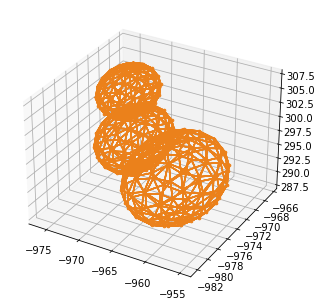

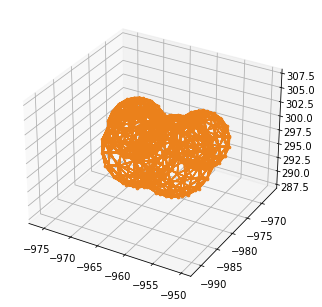

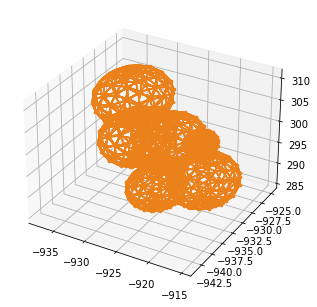

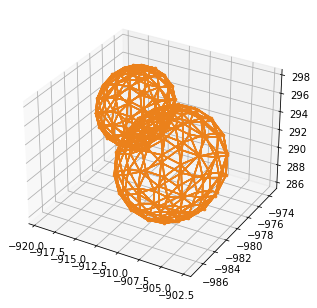

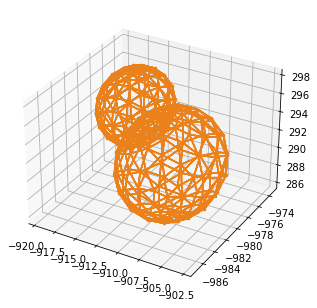

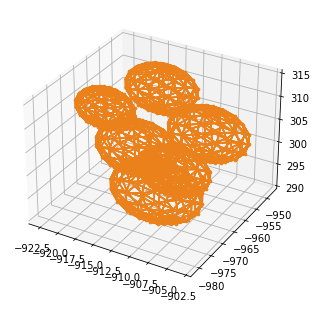

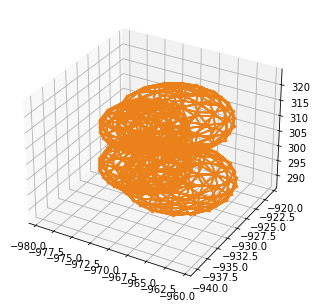

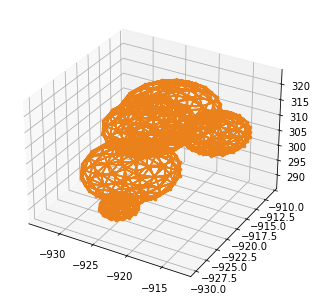

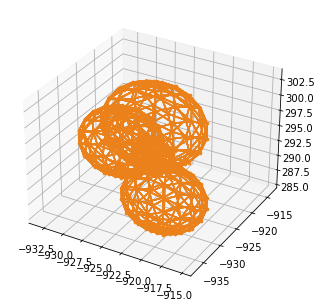

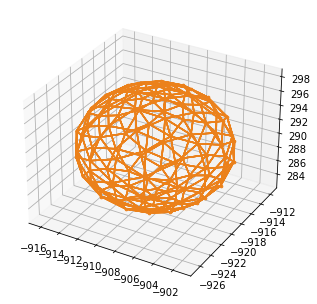

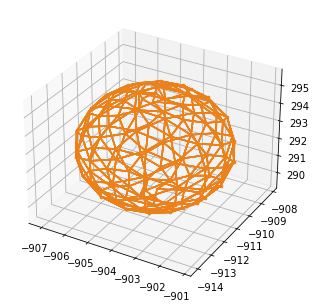

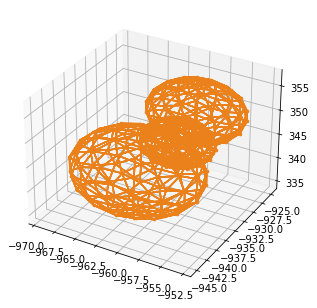

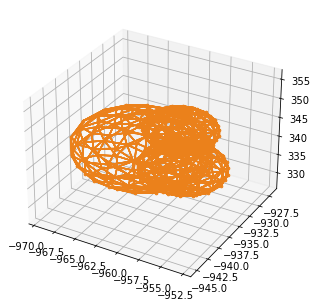

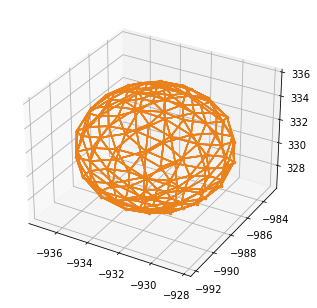

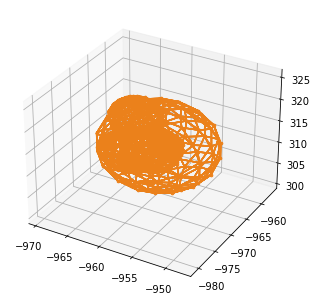

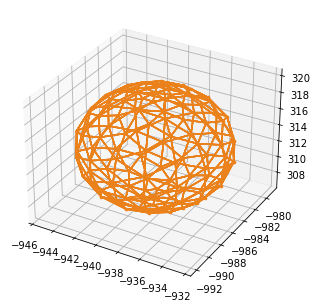

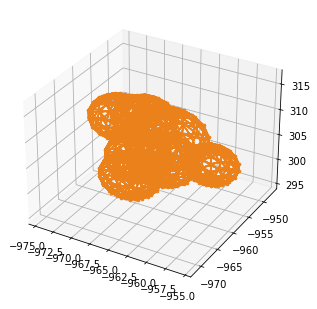

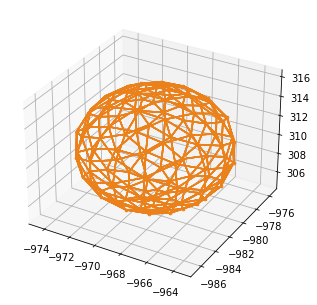

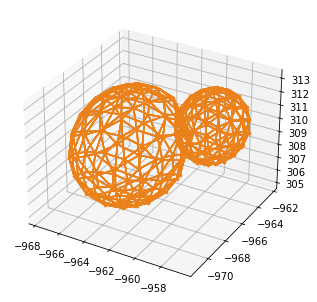

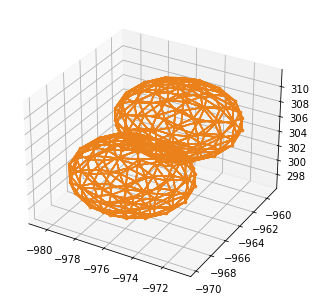

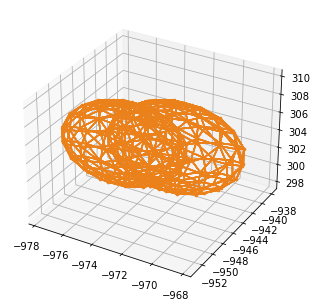

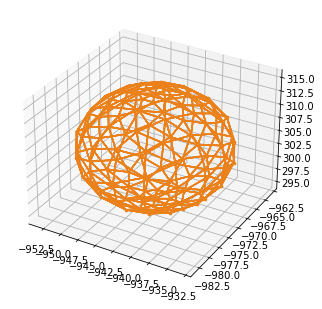

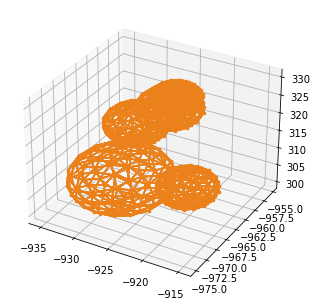

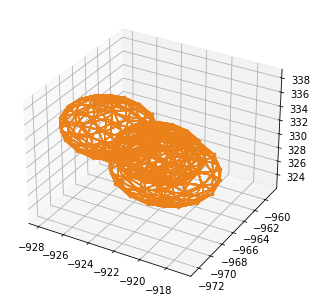

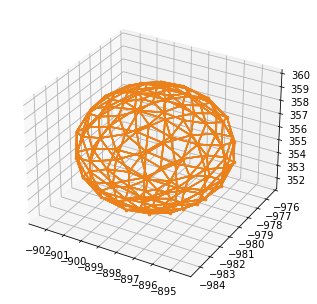

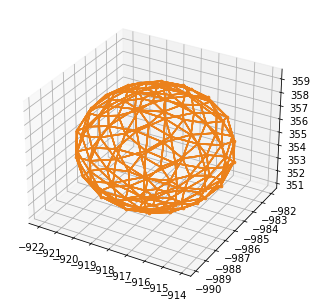

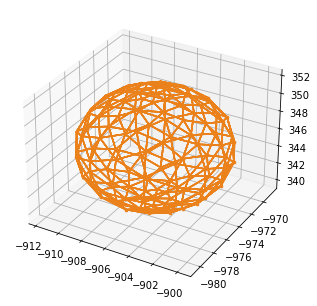

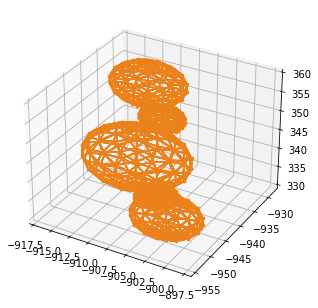

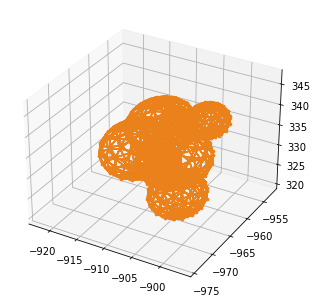

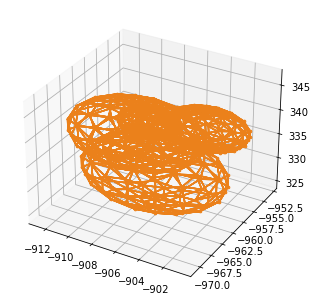

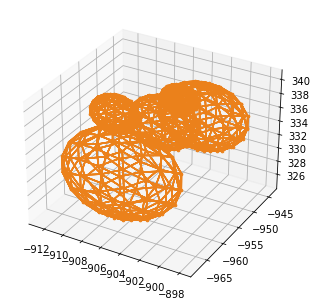

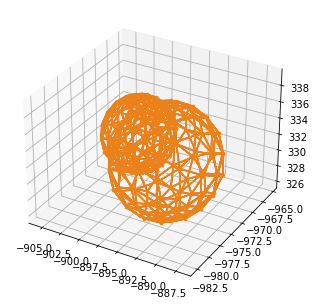

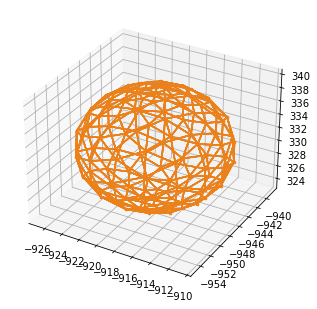

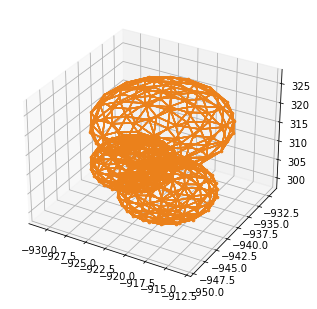

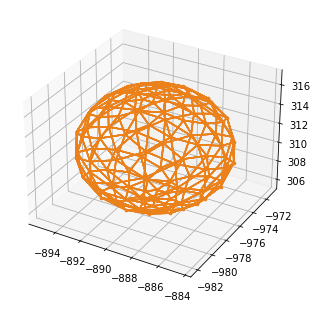

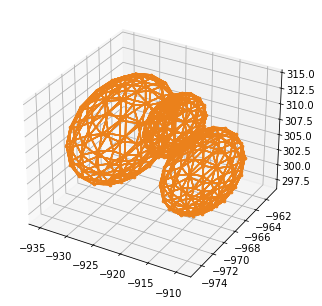

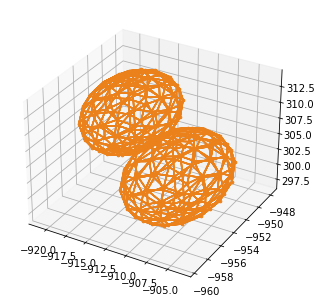

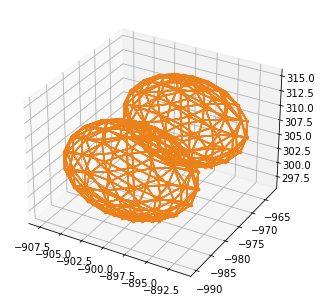

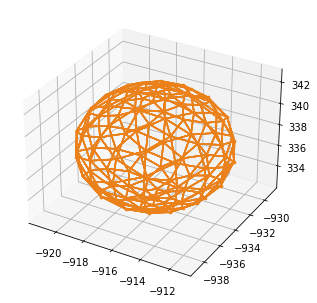

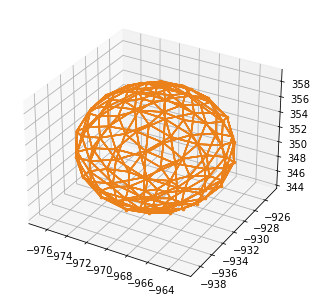

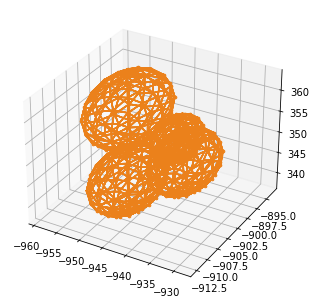

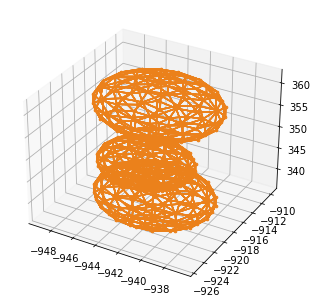

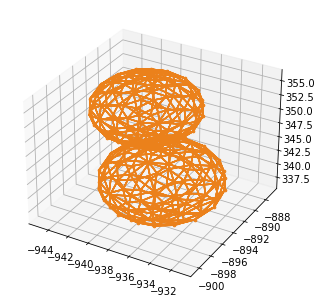

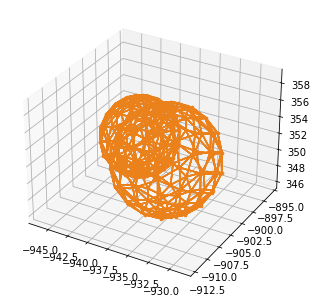

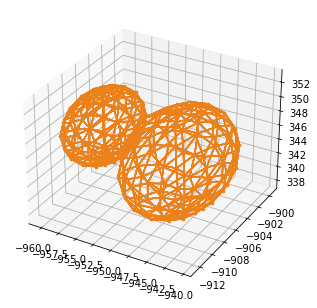

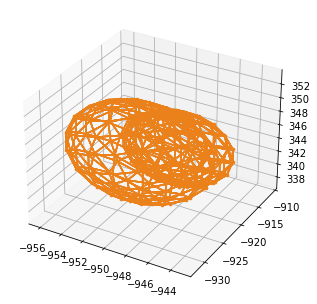

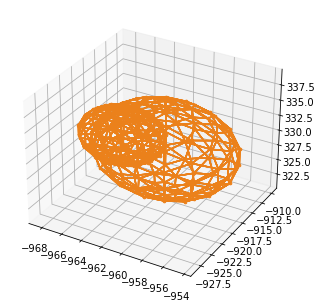

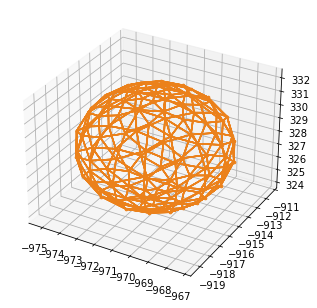

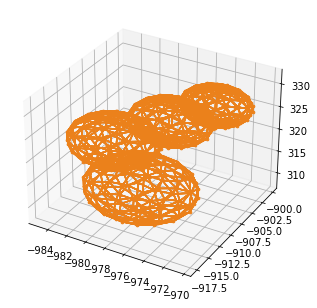

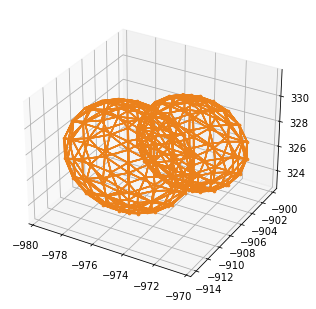

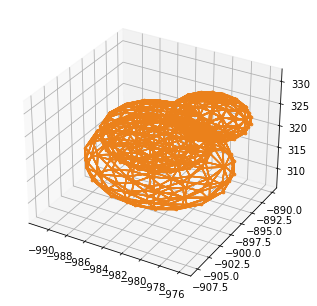

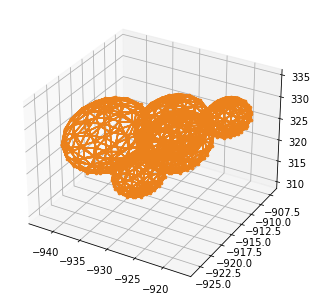

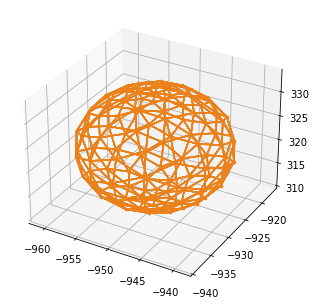

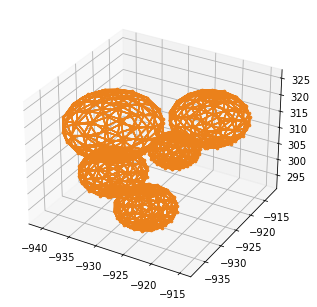

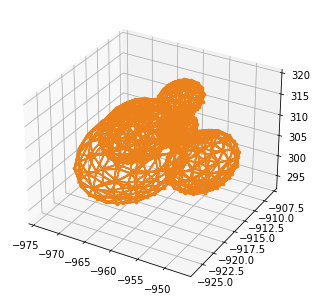

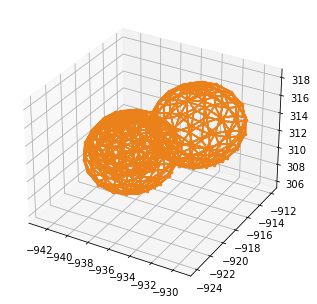

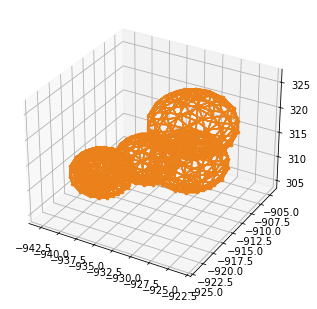

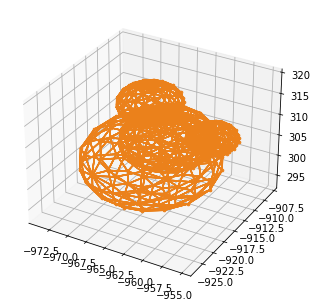

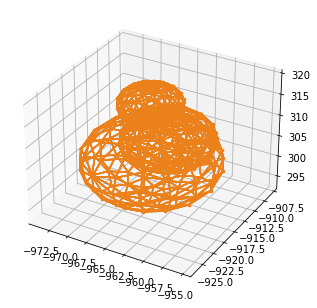

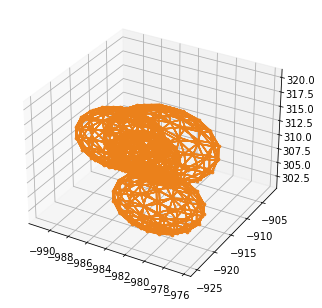

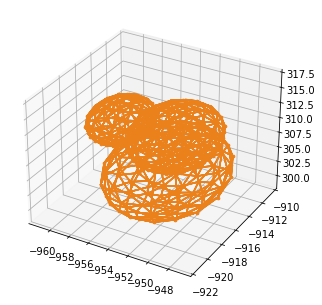

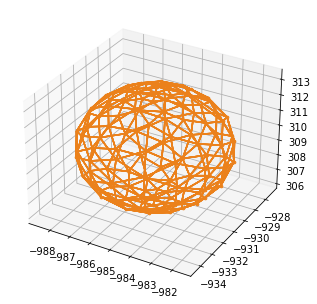

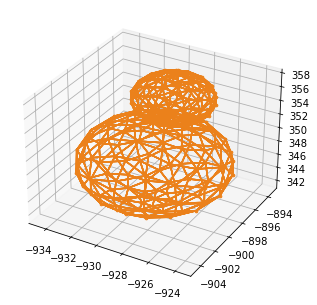

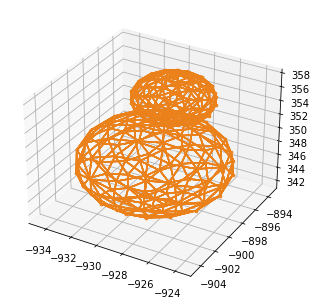

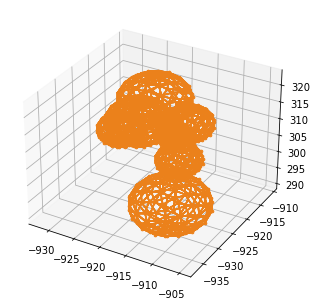

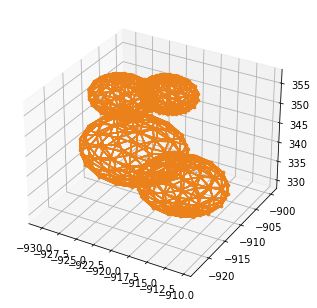

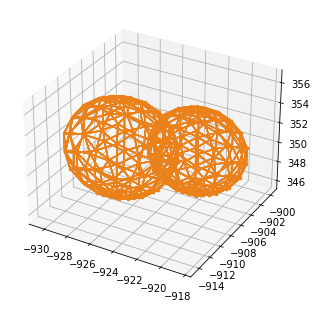

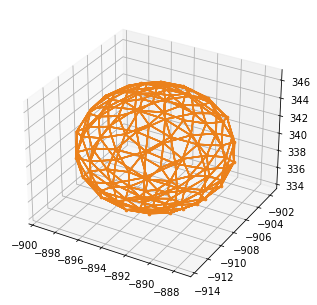

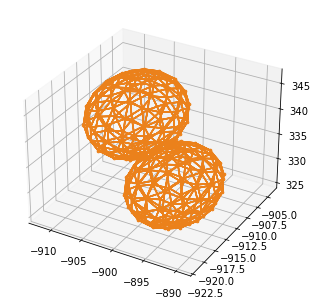

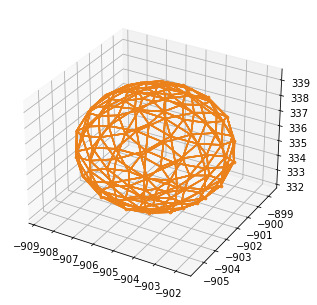

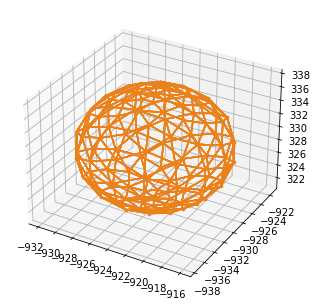

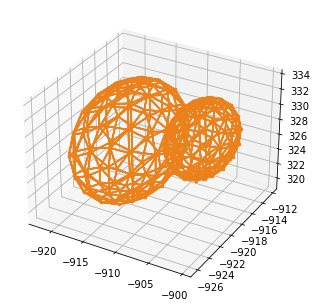

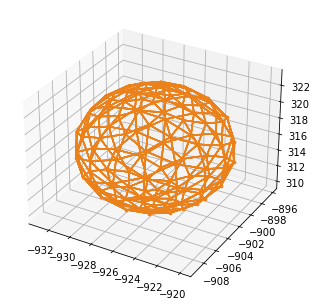

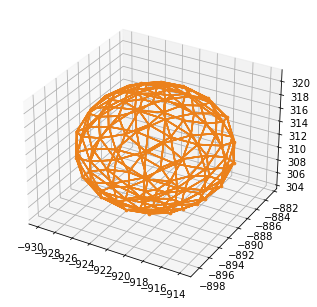

In [17]:
for hc in HC_i_clustered:
    hc.plot_complex()

In [ ]:
# Trim mesh points inside solid particles
if 0:
    for i, hc in enumerate(HC_i_clustered):
        HC = hc
        for v in HC:
            HC.V.remove(v)

In [36]:
# NOTE: Very long loop
HN_i_clustered = []
for i, hc in enumerate(HC_i_clustered):
    HC = hc
    #HN_i.append(c_outd['HN_i'])
    HN_i = []
    for v in HC.V:
        #N_f0 = np.array(
        #    [0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation
        #N_f0 = normalized(N_f0)[0]
        #N_i.append(N_f0)
        N_f0 = np.ones(3)
        F, nn = vectorise_vnn(v)
        # Compute discrete curvatures
        try:
            c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
        except:
            #c_outd = {'HN_i': None}
            c_outd = {'HN_i': 0.0}
        # Append lists
        #HNdA_ij.append(c_outd['HNdA_i'])
        HN_i.append(c_outd['HN_i'])
        
    HN_i_clustered.append(HN_i)

In [35]:
if 0:
    for HN_i in HN_i_clustered:
        for hn_i in HN_i:
            if hn_i is None:
                hn_i = np.mean(HN_i)

In [ ]:
ps.init()
ps.set_up_dir("z_up")
ps_cloud = ps.register_point_cloud("Water ", fluid_all#, radius=100
                                  )
#ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
ps_cloud.add_scalar_quantity("Particle radii", 0.2*np.ones(fluid_all.shape[0]))
ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
#ps_cloud.set_color(tuple(lb))
ps_cloud.set_color(tuple(db))

for i, hc in enumerate(HC_i_clustered):
    HC = hc
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    simplices = np.array(HC.simplices_fm_i)
    ps_mesh = ps.register_surface_mesh(f"Fluid mesh Delaunay {i}", points, simplices, color=lb, transparency=0.8)
    ps_mesh.set_edge_color((0.0, 0.0, 0.0)) 
    ps_mesh.set_edge_width(0.5)
    
    
    # visualize some random data per-vertex
    #vals_vert = np.random.rand(len(points))
    vals_vert = np.array(HN_i_clustered[i])
    ps_mesh.add_scalar_quantity("rand vals", vals_vert, enabled=True, cmap='coolwarm')

    # visualize some random data per-face
    #ps_mesh.add_scalar_quantity("rand vals2", vals_face, defined_on='faces')
    
ps.show()

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v].index = 20
self.V[v].index = 21
self.V[v].index = 22
self.V[v].index = 23
self.V[v].index = 24
self.V[v].index = 25
self.V[v].index = 26
self.V[v].index = 27
self.V[v].index = 28
self.V[v].index = 29
self.V[v].index = 30
self.V[v].index = 31
self.V[v].index = 32
self.V[v].index = 33
self.V[v].index = 34
self.V[v].index = 35
self.V[v].index = 36
self.V[v].index = 37
self.V[v].index = 38
self.V[v].index = 39
self.V[v].index = 40
self.V[v].index = 41
self.V[v].index = 42
self.V[v]

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 633
self.V[v].index = 634
self.V[v].index = 635
self.V[v].index = 636
self.V[v].index = 637
self.V[v].index = 638
self.V[v].index = 639
self.V[v].index = 640
self.V[v].index = 641
self.V[v].index = 642
self.V[v].index = 643
self.V[v].index = 644
self.V[v].index = 645
self.V[v].index = 646
self.V[v].index = 647
self.V[v].index = 648
self.V[v].index = 649
self.V[v].index = 650
self.V[v].index = 651
self.V[v].index = 652
self.V[v].index = 653
self.V[v].index = 654
self.V[v].index = 655
self.V[v].index = 656
self.V[v].index = 657
self.V[v].index = 658
self.V[v].index = 659
self.V[v].index = 660
self.V[v].index = 661
self.V[v].index = 662
self.V[v].index = 663
self.V[v].index = 664
self.V[v].index = 665
self.V[v].index = 666
self.V[v].index = 667
self.V[v].index = 668
self.V[v].index = 669
self.V[v].index = 670
self.V[v].index = 671
self.V[v].index = 672
self.V[v].index = 673
self.V[v].index = 674
self.V[v].index = 675
self.V[v].index = 676
self.V[v].index = 677
self.V[v].

self.V[v].index = 341
self.V[v].index = 342
self.V[v].index = 343
self.V[v].index = 344
self.V[v].index = 345
self.V[v].index = 346
self.V[v].index = 347
self.V[v].index = 348
self.V[v].index = 349
self.V[v].index = 350
self.V[v].index = 351
self.V[v].index = 352
self.V[v].index = 353
self.V[v].index = 354
self.V[v].index = 355
self.V[v].index = 356
self.V[v].index = 357
self.V[v].index = 358
self.V[v].index = 359
self.V[v].index = 360
self.V[v].index = 361
self.V[v].index = 362
self.V[v].index = 363
self.V[v].index = 364
self.V[v].index = 365
self.V[v].index = 366
self.V[v].index = 367
self.V[v].index = 368
self.V[v].index = 369
self.V[v].index = 370
self.V[v].index = 371
self.V[v].index = 372
self.V[v].index = 373
self.V[v].index = 374
self.V[v].index = 375
self.V[v].index = 376
self.V[v].index = 377
self.V[v].index = 378
self.V[v].index = 379
self.V[v].index = 380
self.V[v].index = 381
self.V[v].index = 382
self.V[v].index = 383
self.V[v].index = 384
self.V[v].index = 385
self.V[v].

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v].index = 20
self.V[v].index = 21
self.V[v].index = 22
self.V[v].index = 23
self.V[v].index = 24
self.V[v].index = 25
self.V[v].index = 26
self.V[v].index = 27
self.V[v].index = 28
self.V[v].index = 29
self.V[v].index = 30
self.V[v].index = 31
self.V[v].index = 32
self.V[v].index = 33
self.V[v].index = 34
self.V[v].index = 35
self.V[v].index = 36
self.V[v].index = 37
self.V[v].index = 38
self.V[v].index = 39
self.V[v].index = 40
self.V[v].index = 41
self.V[v].index = 42
self.V[v].index = 43
self.V[v].index = 44
self.V[v].index = 45
self.V[v].index = 46
self.V[v].index = 47
se

self.V[v].index = 556
self.V[v].index = 557
self.V[v].index = 558
self.V[v].index = 559
self.V[v].index = 560
self.V[v].index = 561
self.V[v].index = 562
self.V[v].index = 563
self.V[v].index = 564
self.V[v].index = 565
self.V[v].index = 566
self.V[v].index = 567
self.V[v].index = 568
self.V[v].index = 569
self.V[v].index = 570
self.V[v].index = 571
self.V[v].index = 572
self.V[v].index = 573
self.V[v].index = 574
self.V[v].index = 575
self.V[v].index = 576
self.V[v].index = 577
self.V[v].index = 578
self.V[v].index = 579
self.V[v].index = 580
self.V[v].index = 581
self.V[v].index = 582
self.V[v].index = 583
self.V[v].index = 584
self.V[v].index = 585
self.V[v].index = 586
self.V[v].index = 587
self.V[v].index = 588
self.V[v].index = 589
self.V[v].index = 590
self.V[v].index = 591
self.V[v].index = 592
self.V[v].index = 593
self.V[v].index = 594
self.V[v].index = 595
self.V[v].index = 596
self.V[v].index = 597
self.V[v].index = 598
self.V[v].index = 599
self.V[v].index = 600
self.V[v].

self.V[v].index = 169
self.V[v].index = 170
self.V[v].index = 171
self.V[v].index = 172
self.V[v].index = 173
self.V[v].index = 174
self.V[v].index = 175
self.V[v].index = 176
self.V[v].index = 177
self.V[v].index = 178
self.V[v].index = 179
self.V[v].index = 180
self.V[v].index = 181
self.V[v].index = 182
self.V[v].index = 183
self.V[v].index = 184
self.V[v].index = 185
self.V[v].index = 186
self.V[v].index = 187
self.V[v].index = 188
self.V[v].index = 189
self.V[v].index = 190
self.V[v].index = 191
self.V[v].index = 192
self.V[v].index = 193
self.V[v].index = 194
self.V[v].index = 195
self.V[v].index = 196
self.V[v].index = 197
self.V[v].index = 198
self.V[v].index = 199
self.V[v].index = 200
self.V[v].index = 201
self.V[v].index = 202
self.V[v].index = 203
self.V[v].index = 204
self.V[v].index = 205
self.V[v].index = 206
self.V[v].index = 207
self.V[v].index = 208
self.V[v].index = 209
self.V[v].index = 210
self.V[v].index = 211
self.V[v].index = 212
self.V[v].index = 213
self.V[v].

self.V[v].index = 257
self.V[v].index = 258
self.V[v].index = 259
self.V[v].index = 260
self.V[v].index = 261
self.V[v].index = 262
self.V[v].index = 263
self.V[v].index = 264
self.V[v].index = 265
self.V[v].index = 266
self.V[v].index = 267
self.V[v].index = 268
self.V[v].index = 269
self.V[v].index = 270
self.V[v].index = 271
self.V[v].index = 272
self.V[v].index = 273
self.V[v].index = 274
self.V[v].index = 275
self.V[v].index = 276
self.V[v].index = 277
self.V[v].index = 278
self.V[v].index = 279
self.V[v].index = 280
self.V[v].index = 281
self.V[v].index = 282
self.V[v].index = 283
self.V[v].index = 284
self.V[v].index = 285
self.V[v].index = 286
self.V[v].index = 287
self.V[v].index = 288
self.V[v].index = 289
self.V[v].index = 290
self.V[v].index = 291
self.V[v].index = 292
self.V[v].index = 293
self.V[v].index = 294
self.V[v].index = 295
self.V[v].index = 296
self.V[v].index = 297
self.V[v].index = 298
self.V[v].index = 299
self.V[v].index = 300
self.V[v].index = 301
self.V[v].

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 534
self.V[v].index = 535
self.V[v].index = 536
self.V[v].index = 537
self.V[v].index = 538
self.V[v].index = 539
self.V[v].index = 540
self.V[v].index = 541
self.V[v].index = 542
self.V[v].index = 543
self.V[v].index = 544
self.V[v].index = 545
self.V[v].index = 546
self.V[v].index = 547
self.V[v].index = 548
self.V[v].index = 549
self.V[v].index = 550
self.V[v].index = 551
self.V[v].index = 552
self.V[v].index = 553
self.V[v].index = 554
self.V[v].index = 555
self.V[v].index = 556
self.V[v].index = 557
self.V[v].index = 558
self.V[v].index = 559
self.V[v].index = 560
self.V[v].index = 561
self.V[v].index = 562
self.V[v].index = 563
self.V[v].index = 564
self.V[v].index = 565
self.V[v].index = 566
self.V[v].index = 567
self.V[v].index = 568
self.V[v].index = 569
self.V[v].index = 570
self.V[v].index = 571
self.V[v].index = 572
self.V[v].index = 573
self.V[v].index = 574
self.V[v].index = 575
self.V[v].index = 576
self.V[v].index = 577
self.V[v].index = 578
self.V[v].

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 298
self.V[v].index = 299
self.V[v].index = 300
self.V[v].index = 301
self.V[v].index = 302
self.V[v].index = 303
self.V[v].index = 304
self.V[v].index = 305
self.V[v].index = 306
self.V[v].index = 307
self.V[v].index = 308
self.V[v].index = 309
self.V[v].index = 310
self.V[v].index = 311
self.V[v].index = 312
self.V[v].index = 313
self.V[v].index = 314
self.V[v].index = 315
self.V[v].index = 316
self.V[v].index = 317
self.V[v].index = 318
self.V[v].index = 319
self.V[v].index = 320
self.V[v].index = 321
self.V[v].index = 322
self.V[v].index = 323
self.V[v].index = 324
self.V[v].index = 325
self.V[v].index = 326
self.V[v].index = 327
self.V[v].index = 328
self.V[v].index = 329
self.V[v].index = 330
self.V[v].index = 331
self.V[v].index = 332
self.V[v].index = 333
self.V[v].index = 334
self.V[v].index = 335
self.V[v].index = 336
self.V[v].index = 337
self.V[v].index = 338
self.V[v].index = 339
self.V[v].index = 340
self.V[v].index = 341
self.V[v].index = 342
self.V[v].

self.V[v].index = 343
self.V[v].index = 344
self.V[v].index = 345
self.V[v].index = 346
self.V[v].index = 347
self.V[v].index = 348
self.V[v].index = 349
self.V[v].index = 350
self.V[v].index = 351
self.V[v].index = 352
self.V[v].index = 353
self.V[v].index = 354
self.V[v].index = 355
self.V[v].index = 356
self.V[v].index = 357
self.V[v].index = 358
self.V[v].index = 359
self.V[v].index = 360
self.V[v].index = 361
self.V[v].index = 362
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]


self.V[v].index = 233
self.V[v].index = 234
self.V[v].index = 235
self.V[v].index = 236
self.V[v].index = 237
self.V[v].index = 238
self.V[v].index = 239
self.V[v].index = 240
self.V[v].index = 241
self.V[v].index = 242
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0.

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 161
self.V[v].index = 162
self.V[v].index = 163
self.V[v].index = 164
self.V[v].index = 165
self.V[v].index = 166
self.V[v].index = 167
self.V[v].index = 168
self.V[v].index = 169
self.V[v].index = 170
self.V[v].index = 171
self.V[v].index = 172
self.V[v].index = 173
self.V[v].index = 174
self.V[v].index = 175
self.V[v].index = 176
self.V[v].index = 177
self.V[v].index = 178
self.V[v].index = 179
self.V[v].index = 180
self.V[v].index = 181
self.V[v].index = 182
self.V[v].index = 183
self.V[v].index = 184
self.V[v].index = 185
self.V[v].index = 186
self.V[v].index = 187
self.V[v].index = 188
self.V[v].index = 189
self.V[v].index = 190
self.V[v].index = 191
self.V[v].index = 192
self.V[v].index = 193
self.V[v].index = 194
self.V[v].index = 195
self.V[v].index = 196
self.V[v].index = 197
self.V[v].index = 198
self.V[v].index = 199
self.V[v].index = 200
self.V[v].index = 201
self.V[v].index = 202
self.V[v].index = 203
self.V[v].index = 204
self.V[v].index = 205
self.V[v].

self.V[v].index = 340
self.V[v].index = 341
self.V[v].index = 342
self.V[v].index = 343
self.V[v].index = 344
self.V[v].index = 345
self.V[v].index = 346
self.V[v].index = 347
self.V[v].index = 348
self.V[v].index = 349
self.V[v].index = 350
self.V[v].index = 351
self.V[v].index = 352
self.V[v].index = 353
self.V[v].index = 354
self.V[v].index = 355
self.V[v].index = 356
self.V[v].index = 357
self.V[v].index = 358
self.V[v].index = 359
self.V[v].index = 360
self.V[v].index = 361
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v].index = 20
self.V[v].index = 21
self.V[v].index = 22
self.V[v].index = 23
self.V[v].index = 24
self.V[v].index = 25
self.V[v].index = 26
self.V[v].index = 27
self.V[v].index = 28
self.V[v].index = 29
self.V[v].index = 30
self.V[v].index = 31
self.V[v].index = 32
self.V[v].index = 33
self.V[v].index = 34
self.V[v].index = 35
self.V[v].index = 36
self.V[v].index = 37
self.V[v].index = 38
self.V[v].index = 39
self.V[v].index = 40
self.V[v].index = 41
self.V[v].index = 42
self.V[v]

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
self.V[v].index = 20
self.V[v].index = 21
self.V[v].index = 22
self.V[v].index = 23
self.V[v].index = 24
self.V[v].index = 25
self.V[v].index = 26
self.V[v].index = 27
self.V[v].index = 28
self.V[v].index = 29
self.V[v].index = 30
self.V[v].index = 31
self.V[v].index = 32
self.V[v].index = 33
self.V[v].index = 34
self.V[v].index = 35
self.V[v].index = 36
self.V[v].index = 37
self.V[v].index = 38
self.V[v].index = 39
self.V[v].index = 40
self.V[v].index = 41
self.V[v].index = 42
self.V[v]

self.V[v].index = 107
self.V[v].index = 108
self.V[v].index = 109
self.V[v].index = 110
self.V[v].index = 111
self.V[v].index = 112
self.V[v].index = 113
self.V[v].index = 114
self.V[v].index = 115
self.V[v].index = 116
self.V[v].index = 117
self.V[v].index = 118
self.V[v].index = 119
self.V[v].index = 120
self.V[v].index = 121
self.V[v].index = 122
self.V[v].index = 123
self.V[v].index = 124
self.V[v].index = 125
self.V[v].index = 126
self.V[v].index = 127
self.V[v].index = 128
self.V[v].index = 129
self.V[v].index = 130
self.V[v].index = 131
self.V[v].index = 132
self.V[v].index = 133
self.V[v].index = 134
self.V[v].index = 135
self.V[v].index = 136
self.V[v].index = 137
self.V[v].index = 138
self.V[v].index = 139
self.V[v].index = 140
self.V[v].index = 141
self.V[v].index = 142
self.V[v].index = 143
self.V[v].index = 144
self.V[v].index = 145
self.V[v].index = 146
self.V[v].index = 147
self.V[v].index = 148
self.V[v].index = 149
self.V[v].index = 150
self.V[v].index = 151
self.V[v].

self.V[v].index = 570
self.V[v].index = 571
self.V[v].index = 572
self.V[v].index = 573
self.V[v].index = 574
self.V[v].index = 575
self.V[v].index = 576
self.V[v].index = 577
self.V[v].index = 578
self.V[v].index = 579
self.V[v].index = 580
self.V[v].index = 581
self.V[v].index = 582
self.V[v].index = 583
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

self.V[v].index = 307
self.V[v].index = 308
self.V[v].index = 309
self.V[v].index = 310
self.V[v].index = 311
self.V[v].index = 312
self.V[v].index = 313
self.V[v].index = 314
self.V[v].index = 315
self.V[v].index = 316
self.V[v].index = 317
self.V[v].index = 318
self.V[v].index = 319
self.V[v].index = 320
self.V[v].index = 321
self.V[v].index = 322
self.V[v].index = 323
self.V[v].index = 324
self.V[v].index = 325
self.V[v].index = 326
self.V[v].index = 327
self.V[v].index = 328
self.V[v].index = 329
self.V[v].index = 330
self.V[v].index = 331
self.V[v].index = 332
self.V[v].index = 333
self.V[v].index = 334
self.V[v].index = 335
self.V[v].index = 336
self.V[v].index = 337
self.V[v].index = 338
self.V[v].index = 339
self.V[v].index = 340
self.V[v].index = 341
self.V[v].index = 342
self.V[v].index = 343
self.V[v].index = 344
self.V[v].index = 345
self.V[v].index = 346
self.V[v].index = 347
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

self.V[v].index = 470
self.V[v].index = 471
self.V[v].index = 472
self.V[v].index = 473
self.V[v].index = 474
self.V[v].index = 475
self.V[v].index = 476
self.V[v].index = 477
self.V[v].index = 478
self.V[v].index = 479
self.V[v].index = 480
self.V[v].index = 481
self.V[v].index = 482
self.V[v].index = 483
self.V[v].index = 484
self.V[v].index = 485
self.V[v].index = 486
self.V[v].index = 487
self.V[v].index = 488
self.V[v].index = 489
self.V[v].index = 490
self.V[v].index = 491
self.V[v].index = 492
self.V[v].index = 493
self.V[v].index = 494
self.V[v].index = 495
self.V[v].index = 496
self.V[v].index = 497
self.V[v].index = 498
self.V[v].index = 499
self.V[v].index = 500
self.V[v].index = 501
self.V[v].index = 502
self.V[v].index = 503
self.V[v].index = 504
self.V[v].index = 505
self.V[v].index = 506
self.V[v].index = 507
self.V[v].index = 508
self.V[v].index = 509
self.V[v].index = 510
self.V[v].index = 511
self.V[v].index = 512
self.V[v].index = 513
self.V[v].index = 514
self.V[v].

self.V[v].index = 474
self.V[v].index = 475
self.V[v].index = 476
self.V[v].index = 477
self.V[v].index = 478
self.V[v].index = 479
self.V[v].index = 480
self.V[v].index = 481
self.V[v].index = 482
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [139]:
 ps.show()

In [141]:
# Visualize the previous cell
if 1:
    ps.init()
    ps.set_up_dir("z_up")
    ps_cloud = ps.register_point_cloud("Water ", fluid_all#, radius=100
                                      )
    #ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
    ps_cloud.add_scalar_quantity("Particle radii", 0.2*np.ones(fluid_all.shape[0]))
    ps_cloud.set_point_radius_quantity("Particle radii", autoscale=False)
    #ps_cloud.set_color(tuple(lb))
    ps_cloud.set_color(tuple(db))

    ps_mesh_l = []
    #for hull, pts, ss in zip(hull_l, points, simplices):
    for i, hull in enumerate(hull_l):
        ps_mesh = ps.register_surface_mesh(f"Fluid mesh Delaunay {i}", hull.points, hull.simplices)
        ps_mesh.set_edge_color((0.0, 0.0, 0.0)) 
        ps_mesh.set_edge_width(1.0)
        #ps_mesh.set_material("clay")


    ps.show()

Using DB clustering
=

In [45]:
#dbscan(eps=0.1).fit(points_all)
X = points_all
db = DBSCAN(eps=0.1, min_samples=2).fit(points_all)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_ 

9

<IPython.core.display.Javascript object>


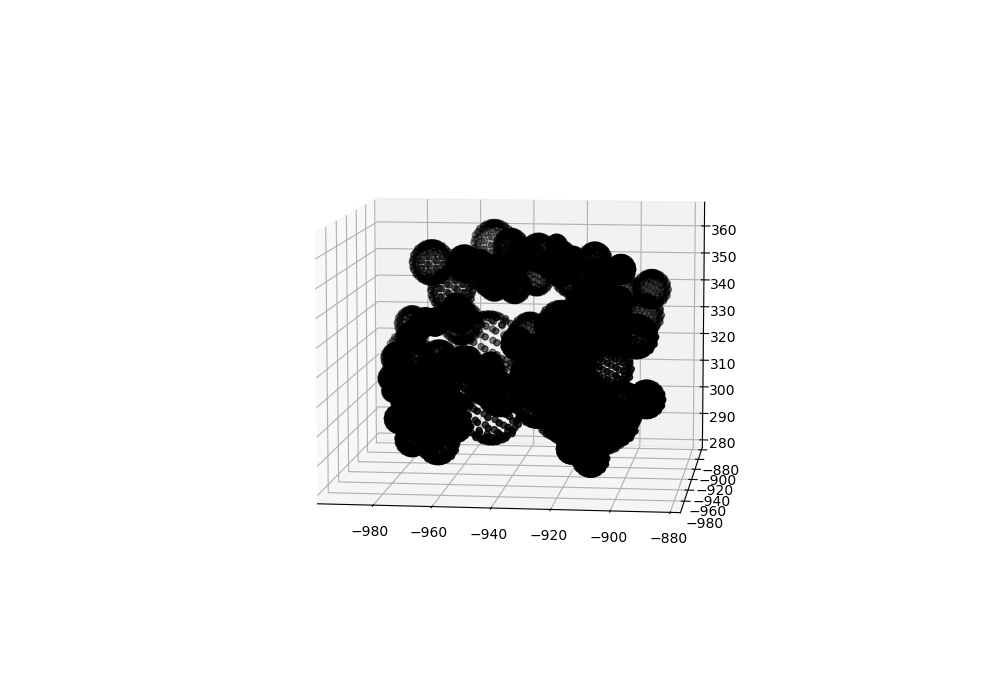

(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
(0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
(0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
(0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
(0.9977700884275279, 0.930872741253364, 0.6330642060745867, 1.0)
(0.944252210688197, 0.9777008842752788, 0.6620530565167244, 1.0)
(0.7477124183006538, 0.8980392156862746, 0.6274509803921569, 1.0)
(0.4530565167243369, 0.7815455594002307, 0.6462898885044214, 1.0)
(0.21607074202229912, 0.5556324490580546, 0.7319492502883507, 1.0)
[0, 0, 0, 1]


In [46]:
%matplotlib notebook
# Plot clusters:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k
    print(col)
    xy = X[class_member_mask & core_samples_mask]
    ax.scatter3D(xy[:, 0], xy[:, 1], xy[:, 2], color=tuple(col))
    xy = X[class_member_mask & ~core_samples_mask]
    ax.scatter3D(xy[:, 0], xy[:, 1], xy[:, 2], color=tuple(col))
    #break
    if 0:
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    
# show plot
plt.show()